In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

path = kagglehub.dataset_download("rameshmehta/credit-risk-analysis")
data_file = 'data.csv'
df = pd.read_csv(f'{path}/{data_file}')

missing_stats = df.isnull().sum()
missing_percent = (missing_stats / len(df)) * 100
missing_df = pd.DataFrame({
    'Feature': missing_stats.index,
    'Missing_Count': missing_stats.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Percentage', ascending=False)
features_with_missing = missing_df[missing_df['Missing_Count'] > 0]

features_to_remove = []
id_patterns = ['id', 'member_id', 'emp_title', 'desc', 'zip_code', 'addr_state', 'verification_status_joint', 'dti_joint', 'annual_inc_joint', 'next_pymnt_d',
               'il_util', 'mths_since_rcnt_il', 'max_bal_bc', 'open_acc_6m', 'open_rv_24m', 'inq_last_12m', 'total_cu_tl', 'inq_fi', 'all_util', 'open_il_6m',
               'open_il_24m', 'open_il_12m', 'total_bal_il', 'open_rv_12m', 'title', 'initial_list_status', 'policy_code', 'last_pymnt_d', 'last_credit_pull_d',
               'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'recoveries', 'collection_recovery_fee',
               'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'out_prncp', 'out_prncp_inv', 'tot_cur_bal', 'mths_since_last_delinq',
               'mths_since_last_major_derog', 'mths_since_last_record', 'funded_amnt', 'funded_amnt_inv', 'installment']

for col in id_patterns:
    features_to_remove.append(col)

df_clean = df.drop(columns=features_to_remove, errors='ignore')
df_clean['emp_length'].fillna(df_clean['emp_length'].mode()[0], inplace=True)
df_clean['total_rev_hi_lim_missing'] = df_clean['total_rev_hi_lim'].isnull().astype(int)
df_clean['total_rev_hi_lim'].fillna(df_clean['total_rev_hi_lim'].median(), inplace=True)
df_clean['revol_util_missing'] = df_clean['revol_util'].isnull().astype(int)
df_clean['revol_util'].fillna(df_clean['revol_util'].median(), inplace=True)

emp_length_order = {
    'n/a': 0,
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
emp_length_mode = df_clean['emp_length'].mode()[0]

grade_mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}
sub_grades = [f"{g}{n}" for g in "ABCDEFG" for n in range(1, 6)]
sub_grade_mapping = {sub: idx for idx, sub in enumerate(sub_grades)}

df_clean['emp_length'] = df_clean['emp_length'].map(emp_length_order).fillna(emp_length_mode)
df_clean['grade'] = df_clean['grade'].map(grade_mapping)
df_clean['sub_grade'] = df_clean['sub_grade'].map(sub_grade_mapping)

categorical_cols = [
    'term', 'home_ownership', 'verification_status',
    'pymnt_plan', 'purpose', 'application_type'
]

date_cols = [
    'issue_d', 'earliest_cr_line']

for col in date_cols:
    df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

reference_date = pd.Timestamp('2007-01-01')
for col in date_cols:
    df_clean[f'{col}_year'] = df_clean[col].dt.year.fillna(2007).astype(int)
    df_clean[f'{col}_month'] = df_clean[col].dt.month.fillna(1).astype(int)
    df_clean[f'{col}_days_since'] = (reference_date - df_clean[col]).dt.days.fillna(9999).astype(int)
df_clean.drop(columns=date_cols, inplace=True)

numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'default_ind' in numerical_cols:
    numerical_cols.remove('default_ind')

constant_features = []
for col in numerical_cols:
    if df_clean[col].nunique() <= 1:
        constant_features.append(col)
numerical_cols = [col for col in numerical_cols if col not in constant_features]

try:
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    df_clean[numerical_cols] = pt.fit_transform(df_clean[numerical_cols])
except Exception as e:
    scaler = StandardScaler()
    df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])

df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
bool_cols = df_clean.select_dtypes(include='bool').columns
df_clean[bool_cols] = df_clean[bool_cols].astype(int)

df_clean2 = df_clean.copy()

X = df_clean2.drop(columns=['default_ind'])
y = df_clean2['default_ind']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)


X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled,
    test_size=0.30,
    random_state=42,
    stratify=y_resampled
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)


features_to_remove = [
    'grade', 'sub_grade'
]

X_test_subset = X_test.drop(columns=features_to_remove, errors='ignore')

X_test_subset_aligned = X_test_subset.reindex(columns=X_train.columns, fill_value=0)

100%|██████████| 89.6M/89.6M [00:01<00:00, 75.7MB/s]

Extracting files...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')
import kagglehub
from sklearn.preprocessing import PowerTransformer

path = kagglehub.dataset_download("laotse/credit-risk-dataset")
print("Path to dataset files:", path)

df = pd.read_csv(os.path.join(path, "credit_risk_dataset.csv"))
print(df.head())

print("="*60)
print("INITIAL DATA")
print("="*60)

# Basic dataset information
print(f"Dataset shape: {df.shape}")

# Basic statistics
print(f"\nDataset Info:")
print(f"  - Total records: {len(df):,}")
print(f"  - Total features: {df.shape[1]}")
print(f"  - Numerical features: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"  - Categorical features: {len(df.select_dtypes(include=['object']).columns)}")

# Check for missing values
print("\nMissing Value Analysis:")
missing_stats = df.isnull().sum()
missing_percent = (missing_stats / len(df)) * 100
missing_df = pd.DataFrame({
    'Feature': missing_stats.index,
    'Missing_Count': missing_stats.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Percentage', ascending=False)

# Display features with missing values
features_with_missing = missing_df[missing_df['Missing_Count'] > 0]
if len(features_with_missing) > 0:
    print(f"Features with missing values: {len(features_with_missing)}")
    print(features_with_missing.head)

print("\n" + "="*60)
print("FEATURE CLEANING")
print("="*60)

features_to_remove = []

# Remove description and missing value columns
id_patterns = ['person_age', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

for col in id_patterns:
    features_to_remove.append(col)

print(f"Features to remove ({len(features_to_remove)}):")
for feature in features_to_remove:
    print(f"  - {feature}")

# Remove features
df_clean_new = df.drop(columns=features_to_remove, errors='ignore')


feature_mapping = {
    'person_income': 'annual_inc',
    'person_home_ownership': 'home_ownership',
    'person_emp_length': 'emp_length',
    'loan_intent': 'purpose',
    'loan_grade': 'grade',
    'loan_amnt': 'loan_amnt',
    'loan_int_rate': 'int_rate',
    'loan_status': 'default_ind',
}

df_mapped = df_clean_new.rename(columns=feature_mapping)

print("Original columns:")
print(df_clean_new.columns.tolist())

print("\nMapped columns:")
print(df_mapped.columns.tolist())

# Fill missing values
df_mapped['int_rate'].fillna(df_mapped['int_rate'].mode()[0], inplace=True)

# Create missing flag + fill with 0
df_mapped['emp_length'].fillna(df_mapped['emp_length'].median(), inplace=True)

print(f"\nData Shape: {df_mapped.shape}")
print(df_mapped.head(3))

def bin_emp_length(val):
    if pd.isnull(val):
        return 0
    elif val < 1:
        return 1
    elif val >= 10:
        return 11
    else:
        return int(val) + 1
emp_length_mode = df_mapped['emp_length'].mode()[0]
df_mapped['emp_length'].fillna(emp_length_mode, inplace=True)
df_mapped['emp_length'] = df_mapped['emp_length'].apply(bin_emp_length)
df_encoded = pd.get_dummies(df_mapped, columns=['emp_length'], prefix='emp_length')

home_categories = ['MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT']
df_mapped['home_ownership'] = pd.Categorical(df_mapped['home_ownership'], categories=home_categories)
df_encoded = pd.get_dummies(df_mapped, columns=['home_ownership'], prefix='home_ownership')
for col in [f'home_ownership_{cat}' for cat in home_categories]:
    if col not in df_encoded.columns:
        df_encoded[col] = 0
print(df_encoded.filter(like='home_ownership_').head())

purpose_categories = [
    'credit_card',
    'debt_consolidation',
    'educational',
    'home_improvement',
    'house',
    'major_purchase',
    'medical',
    'moving',
    'other',
    'renewable_energy',
    'small_business',
    'vacation',
    'wedding'
]
purpose_map = {
    'EDUCATION': 'educational',
    'VENTURE': 'small_business',
    'MEDICAL': 'medical',
    'PERSONAL': 'other',
    'DEBTCONSOLIDATION': 'debt_consolidation'
}
df_encoded['purpose'] = df_encoded['purpose'].map(purpose_map).fillna('other')
df_encoded['purpose'] = pd.Categorical(df_encoded['purpose'], categories=purpose_categories)
df_encoded = pd.get_dummies(df_encoded, columns=['purpose'], prefix='purpose')
for col in [f'purpose_{cat}' for cat in purpose_categories]:
    if col not in df_encoded.columns:
        df_encoded[col] = 0
print(df_encoded.filter(like='purpose_').head())

grade_mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}
df_encoded['grade'] = df_encoded['grade'].map(grade_mapping)


# Normalize numerical features
numerical_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
if 'default_ind' in numerical_cols:
    numerical_cols.remove('default_ind')

constant_features = []
for col in numerical_cols:
    if df_encoded[col].nunique() <= 1:
        constant_features.append(col)
numerical_cols = [col for col in numerical_cols if col not in constant_features]

# Apply PowerTransformer to remaining features
try:
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    df_encoded[numerical_cols] = pt.fit_transform(df_encoded[numerical_cols])
except Exception as e:
    scaler = StandardScaler()
    df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df_clean_new = df_encoded.copy()

print("="*60)
print("DATASET STATS AFTER CLEANING")
print("="*60)

print(f"Shape after cleaning: {df_clean_new.shape}")
print(f"Number of numerical features: {len(df_clean_new.select_dtypes(include=[np.number]).columns)}")
print(f"Number of categorical features: {len(df_clean_new.select_dtypes(include=['uint8', 'category']).columns)}")

print("\nMissing values per feature after cleaning:")
missing_after = df_clean_new.isnull().sum()
missing_after = missing_after[missing_after > 0]
if missing_after.empty:
    print("None")
else:
    print(missing_after)

df_clean_new2 = df_clean_new.copy()
X = df_clean_new2.drop(columns=['default_ind'])
y = df_clean_new2['default_ind']

rus = RandomUnderSampler(random_state=42)
X_resampled_new, y_resampled_new = rus.fit_resample(X, y)

print("\n" + "="*60)
print("TARGET VARIABLE ANALYSIS - BEFORE UNDERSAMPLING")
print("="*60)

target_col = 'default_ind'

if target_col:
    target_distribution = y.value_counts()
    print(f"Target distribution:")
    for value, count in target_distribution.items():
        print(f"  {value}: {count:,} ({count/len(y)*100:.2f}%)")

print("\n" + "="*60)
print("TARGET VARIABLE ANALYSIS - AFTER UNDERSAMPLING")
print("="*60)

if target_col:
    resampled_distribution = pd.Series(y_resampled_new).value_counts()
    total_resampled = len(y_resampled_new)
    print(f"Target distribution:")
    for value, count in resampled_distribution.items():
        print(f"  {value}: {count:,} ({count/total_resampled*100:.2f}%)")

feature_names = X_train.columns.tolist()
X_test_new_aligned = X_resampled_new.reindex(columns=feature_names, fill_value=0)

Path to dataset files: /kaggle/input/credit-risk-dataset
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59

Training AUC-ROC Score: 0.8128
Validation AUC-ROC Score: 0.8167
Testing AUC-ROC Score: 0.8120
Testing (Subset) AUC-ROC Score: 0.7732
Testing (New) AUC-ROC Score: 0.7216
Training Classification Report
              precision    recall  f1-score   support

           0   0.739690  0.735596  0.737637     32526
           1   0.737059  0.741138  0.739093     32527

    accuracy                       0.738367     65053
   macro avg   0.738374  0.738367  0.738365     65053
weighted avg   0.738374  0.738367  0.738365     65053

Validation Classification Report
              precision    recall  f1-score   support

           0   0.740603  0.740603  0.740603      6970
           1   0.740603  0.740603  0.740603      6970

    accuracy                       0.740603     13940
   macro avg   0.740603  0.740603  0.740603     13940
weighted avg   0.740603  0.740603  0.740603     13940

Testing Classification Report
              precision    recall  f1-score   support

           0   0.740344  0.7

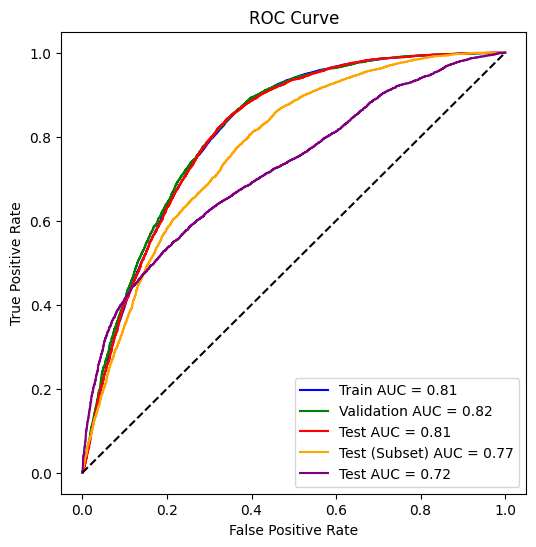

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc

logreg_model = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg_model.fit(X_train, y_train)

y_train_probs = logreg_model.predict_proba(X_train)[:, 1]
y_train_preds = logreg_model.predict(X_train)

y_val_probs = logreg_model.predict_proba(X_val)[:, 1]
y_val_preds = logreg_model.predict(X_val)

y_test_probs = logreg_model.predict_proba(X_test)[:, 1]
y_test_preds = logreg_model.predict(X_test)

y_test_subset_probs = logreg_model.predict_proba(X_test_subset_aligned)[:, 1]
y_test_subset_preds = logreg_model.predict(X_test_subset_aligned)

y_test_new_probs = logreg_model.predict_proba(X_test_new_aligned)[:, 1]
y_test_new_preds = logreg_model.predict(X_test_new_aligned)

auc_score_train = roc_auc_score(y_train, y_train_probs)
auc_score_val = roc_auc_score(y_val, y_val_probs)
auc_score_test = roc_auc_score(y_test, y_test_probs)
auc_score_test_subset = roc_auc_score(y_test, y_test_subset_probs)
auc_score_test_new = roc_auc_score(y_resampled_new, y_test_new_probs)

print(f"Training AUC-ROC Score: {auc_score_train:.4f}")
print(f"Validation AUC-ROC Score: {auc_score_val:.4f}")
print(f"Testing AUC-ROC Score: {auc_score_test:.4f}")
print(f"Testing (Subset) AUC-ROC Score: {auc_score_test_subset:.4f}")
print(f"Testing (New) AUC-ROC Score: {auc_score_test_new:.4f}")

print("Training Classification Report")
print(classification_report(y_train, y_train_preds, digits=6))

print("Validation Classification Report")
print(classification_report(y_val, y_val_preds, digits=6))

print("Testing Classification Report")
print(classification_report(y_test, y_test_preds, digits=6))

print("Testing (Subset) Classification Report")
print(classification_report(y_test, y_test_subset_preds, digits=6))

print("Testing (New) Classification Report")
print(classification_report(y_resampled_new, y_test_new_preds, digits=6))

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
fpr_test_subset, tpr_test_subset, _ = roc_curve(y_test, y_test_subset_probs)
fpr_test_new, tpr_test_new, _ = roc_curve(y_resampled_new, y_test_new_probs)

plt.figure(figsize=(6,6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train AUC = {auc_score_train:.2f}')
plt.plot(fpr_val, tpr_val, color='green', label=f'Validation AUC = {auc_score_val:.2f}')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test AUC = {auc_score_test:.2f}')
plt.plot(fpr_test_subset, tpr_test_subset, color='orange', label=f'Test (Subset) AUC = {auc_score_test_subset:.2f}')
plt.plot(fpr_test_new, tpr_test_new, color='purple', label=f'Test AUC = {auc_score_test_new:.2f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import random
import pickle

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def prepare_data(df_clean, df_clean_new):
    #  Separate features and target
    X = df_clean.drop(columns=['default_ind'])
    y = df_clean['default_ind']
    X_new = df_clean_new.drop(columns=['default_ind'])
    y_new = df_clean_new['default_ind']

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    rus_new = RandomUnderSampler(random_state=42)
    X_resampled_new, y_resampled_new = rus_new.fit_resample(X_new, y_new)

    # Train/Val/Test split (70/15/15) with stratification. WE could have gone with 80/10/10 too.
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_resampled, y_resampled, test_size=0.30, stratify=y_resampled, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
    )

    features_to_remove = [
        'grade', 'sub_grade'
    ]

    X_test_subset = X_test.drop(columns=features_to_remove, errors='ignore')
    X_test_subset_aligned = X_test_subset.reindex(columns=X_train.columns, fill_value=0)

    X_test_new_aligned = X_resampled_new.reindex(columns=X_train.columns, fill_value=0)

    # Standardize features (fit on train only)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)
    X_test_subset_scaled = pd.DataFrame(scaler.transform(X_test_subset_aligned), columns=X_train.columns)
    x_test_new_scaled = pd.DataFrame(scaler.transform(X_test_new_aligned), columns=X_train.columns)

    # Wrap in PyTorch Dataset
    train_dataset = TabularDataset(X_train_scaled, y_train)
    val_dataset = TabularDataset(X_val_scaled, y_val)
    test_dataset = TabularDataset(X_test_scaled, y_test)
    test_subset_dataset = TabularDataset(X_test_subset_scaled, y_test)
    test_new_dataset = TabularDataset(x_test_new_scaled, y_resampled_new)

    return train_dataset, val_dataset, test_dataset, test_subset_dataset, test_new_dataset, X.columns.tolist()

def create_loaders(train_dataset, val_dataset, test_dataset, test_subset_dataset, test_new_dataset, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_subset_loader = DataLoader(test_subset_dataset, batch_size=batch_size, shuffle=False)
    test_new_loader = DataLoader(test_new_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, test_subset_loader, test_new_loader

class AttentionBranch(nn.Module):
    def __init__(self, input_dim, embed_dim=32, num_heads=4, dropout=0.1):
        super(AttentionBranch, self).__init__()
        self.input_dim = input_dim      # Number of features
        self.embed_dim = embed_dim      # Embedding size per feature
        self.num_heads = num_heads

        # 1. Feature embedding layer: project each scalar feature to a vector
        # Input: (batch_size, input_dim) → Output: (batch_size, input_dim, embed_dim)
        self.feature_embedding = nn.Linear(1, embed_dim)

        # 2. Multi-head self-attention layer
        # PyTorch MultiheadAttention expects shape: (seq_len, batch, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)

        # 3. Final projection after attention (optional)
        self.output_proj = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, input_dim)
        """
        batch_size, input_dim = x.shape

        # Step 1: Embed each feature separately

        # Reshape to (batch_size * input_dim, 1) to embed each scalar feature
        x_reshaped = x.view(-1, 1)  # (batch_size*input_dim, 1)
        embedded = self.feature_embedding(x_reshaped)  # (batch_size*input_dim, embed_dim)
        embedded = embedded.view(batch_size, input_dim, self.embed_dim)  # (batch_size, input_dim, embed_dim)

        embedded = embedded.permute(1, 0, 2)  # (input_dim, batch_size, embed_dim)

        attn_output, attn_weights = self.attention(embedded, embedded, embedded)
        # attn_output shape: (input_dim, batch_size, embed_dim)

        attn_output = self.dropout(attn_output)
        out = self.layernorm(attn_output + embedded)  # (input_dim, batch_size, embed_dim)

        out = self.output_proj(out)  # (input_dim, batch_size, embed_dim)
        out = out.permute(1, 0, 2).contiguous()  # (batch_size, input_dim, embed_dim)
        out = out.view(batch_size, -1)  # flatten all features: (batch_size, input_dim * embed_dim)

        return out, attn_weights  # return output and attention weights for interpretability


# MLP branch: stack of fully connected layers with ReLU and dropout
class MLPBranch(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], dropout=0.1):
        super(MLPBranch, self).__init__()
        layers = []
        in_dim = input_dim

        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h_dim

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)  # (batch_size, last_hidden_dim)

class HybridAttentionNet(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim=32,
        num_heads=4,
        mlp_hidden_dims=[64, 32, 16],
        dropout=0.1,
    ):
        super(HybridAttentionNet, self).__init__()

        # Attention branch
        self.attention_branch = AttentionBranch(input_dim, embed_dim, num_heads, dropout)

        # MLP branch
        self.mlp_branch = MLPBranch(input_dim, mlp_hidden_dims, dropout)

        # Fusion layer: combine attention output and MLP output
        fusion_input_dim = input_dim * embed_dim + mlp_hidden_dims[-1]
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),  # final output = probability of default
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Attention branch output (flattened)
        attn_out, attn_weights = self.attention_branch(x)  # (batch_size, input_dim * embed_dim)

        # MLP branch output
        mlp_out = self.mlp_branch(x)  # (batch_size, last_hidden_dim)

        # Concatenate features from both branches
        combined = torch.cat([attn_out, mlp_out], dim=1)  # (batch_size, fusion_input_dim)

        # Pass through fusion layers to get final probability
        output = self.fusion_layer(combined)  # (batch_size, 1)

        return output, attn_weights  # output

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs, _ = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        all_preds.append(outputs.detach().cpu())
        all_targets.append(y_batch.detach().cpu())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_preds_label = (all_preds >= 0.5).astype(int)

    epoch_auc = roc_auc_score(all_targets, all_preds)
    epoch_precision = precision_score(all_targets, all_preds_label)
    epoch_recall = recall_score(all_targets, all_preds_label)
    epoch_accuracy = accuracy_score(all_targets, all_preds_label)


    return epoch_loss, epoch_auc, epoch_precision, epoch_recall, epoch_accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            all_preds.append(outputs.cpu())
            all_targets.append(y_batch.cpu())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_preds_label = (all_preds >= 0.5).astype(int)

    epoch_auc = roc_auc_score(all_targets, all_preds)
    epoch_precision = precision_score(all_targets, all_preds_label)
    epoch_recall = recall_score(all_targets, all_preds_label)
    epoch_accuracy = accuracy_score(all_targets, all_preds_label)


    return epoch_loss, epoch_auc, epoch_precision, epoch_recall, epoch_accuracy

def train_model(
    model,
    train_loader,
    val_loader,
    n_epochs=20,
    lr=1e-3,
    device=None,
    save_path="best_model.pth"
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    history = {
        'train_loss': [],
        'train_auc': [],
        'train_acc': [],
        'val_loss': [],
        'val_auc': [],
        'val_acc': []
    }

    best_val_auc = 0.0

    for epoch in range(1, n_epochs + 1):
        train_loss, train_auc, train_prec, train_rec, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_auc, val_prec, val_rec, val_acc = eval_epoch(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_auc'].append(train_auc)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['val_acc'].append(val_acc)

        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f} | Train Precision: {train_prec:.4f} | Train Recall: {train_rec:.4f} | Train Accuracy: {train_acc:.4f} || "
            f"Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f} | Val Precision: {val_prec:.4f} | Val Recall: {val_rec:.4f} | Val Accuracy: {val_acc:.4f}"
        )

        # Save model if validation AUC improves
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), save_path)
            print(f"--> Saved best model with Val AUC: {best_val_auc:.4f}")

    print("Training complete.")
    print(f"Best Val AUC: {best_val_auc:.4f}")

    # Load best model weights before returning
    model.load_state_dict(torch.load(save_path))
    return model, history

def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs, _ = model(X_batch)
            all_preds.append(outputs.cpu())
            all_targets.append(y_batch.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_preds_label = (all_preds >= 0.5).astype(int)

    auc = roc_auc_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds_label)
    recall = recall_score(all_targets, all_preds_label)
    accuracy = accuracy_score(all_targets, all_preds_label)

    print(f"Test AUC: {auc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

def calculate_fit_metrics(epochs, values):
    coeffs = np.polyfit(epochs, values, 1)
    fit_line = np.polyval(coeffs, epochs)
    residuals = np.array(values) - fit_line
    r2 = 1 - (np.sum(residuals**2) / np.sum((np.array(values) - np.mean(values))**2))
    equation = f"y = {coeffs[0]:.4f}x + {coeffs[1]:.4f}"
    return r2, residuals, equation, fit_line

def plot_loss_and_auc_with_fit(history):
    epochs = np.arange(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 6))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Auc subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_auc'], label='Train AUC', color='blue')
    plt.plot(epochs, history['val_auc'], label='Val AUC', color='orange')

    train_r2, train_res, train_eq, train_fit = calculate_fit_metrics(epochs, history['train_auc'])
    val_r2, val_res, val_eq, val_fit = calculate_fit_metrics(epochs, history['val_auc'])

    plt.plot(epochs, train_fit, '--', color='blue', label=f'Train Fit (R²={train_r2:.3f})')
    plt.plot(epochs, val_fit, '--', color='orange', label=f'Val Fit (R²={val_r2:.3f})')

    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC per Epoch with Best Fit Lines')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'train_r2': train_r2,
        'train_residuals': train_res,
        'train_equation': train_eq,
        'val_r2': val_r2,
        'val_residuals': val_res,
        'val_equation': val_eq
    }

def get_preds_probs_labels(model, dataloader, device):
    model.eval()
    all_probs, all_targets = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            outputs, _ = model(X)
            all_probs.append(outputs.cpu())
            all_targets.append(y)
    probs = torch.cat(all_probs).numpy().flatten()
    targets = torch.cat(all_targets).numpy().flatten()
    preds = (probs >= 0.5).astype(int)
    return targets, probs, preds

def print_metrics_and_plot_roc(model, train_loader, val_loader, test_loader, device):
    y_train, y_train_probs, y_train_preds = get_preds_probs_labels(model, train_loader, device)
    y_val, y_val_probs, y_val_preds = get_preds_probs_labels(model, val_loader, device)
    y_test, y_test_probs, y_test_preds = get_preds_probs_labels(model, test_loader, device)
    y_test_subset, y_test_subset_probs, y_test_subset_preds = get_preds_probs_labels(model, test_subset_loader, device)
    y_test_new, y_test_new_probs, y_test_new_preds = get_preds_probs_labels(model, test_new_loader, device)

    # Print metrics
    for name, y_true, y_prob, y_pred in [
        ("Training", y_train, y_train_probs, y_train_preds),
        ("Validation", y_val, y_val_probs, y_val_preds),
        ("Testing", y_test, y_test_probs, y_test_preds),
        ("Subset Testing", y_test_subset, y_test_subset_probs, y_test_subset_preds),
        ("New Testing", y_test_new, y_test_new_probs, y_test_new_preds)
    ]:
        auc_score = roc_auc_score(y_true, y_prob)
        print(f"{name} AUC-ROC Score: {auc_score:.4f}")
        print(f"{name} Classification Report:")
        print(classification_report(y_true, y_pred, digits=6))
        print()

    # Compute ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    fpr_test_subset, tpr_test_subset, _ = roc_curve(y_test_subset, y_test_subset_probs)
    fpr_test_new, tpr_test_new, _ = roc_curve(y_test_new, y_test_new_probs)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))

    axs[0].plot(fpr_train, tpr_train, color='blue', label=f'Train AUC = {roc_auc_score(y_train, y_train_probs):.2f}')
    axs[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axs[0].set_title('ROC Curve - Train Set')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend(loc='lower right')
    axs[0].grid(True)

    axs[1].plot(fpr_val, tpr_val, color='green', label=f'Val AUC = {roc_auc_score(y_val, y_val_probs):.2f}')
    axs[1].plot([0, 1], [0, 1], 'k--', lw=1)
    axs[1].set_title('ROC Curve - Validation Set')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].legend(loc='lower right')
    axs[1].grid(True)

    fig, axs = plt.subplots(1, 2, figsize=(18, 5))

    axs[0].plot(fpr_test, tpr_test, color='red', label=f'Test AUC = {roc_auc_score(y_test, y_test_probs):.2f}')
    axs[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axs[0].set_title('ROC Curve - Test Set')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend(loc='lower right')
    axs[0].grid(True)

    axs[1].plot(fpr_test_subset, tpr_test_subset, color='orange', label=f'Subset Test AUC = {roc_auc_score(y_test_subset, y_test_subset_probs):.2f}')
    axs[1].plot([0, 1], [0, 1], 'k--', lw=1)
    axs[1].set_title('ROC Curve - Subset Test Set')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].legend(loc='lower right')
    axs[1].grid(True)

    fig, axs = plt.subplots(1, 2, figsize=(18, 5))
    axs[0].plot(fpr_test_new, tpr_test_new, color='purple', label=f'New Test AUC = {roc_auc_score(y_test_new, y_test_new_probs):.2f}')
    axs[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axs[0].set_title('ROC Curve - New Test Set')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend(loc='lower right')
    axs[0].grid(True)

    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
from pathlib import Path
import pickle
import numpy as np

def load_trial_summaries(pkl_path):
    with open(pkl_path, 'rb') as f:
        return pickle.load(f)

def load_model(model_path, input_dim, embed_dim, num_heads, mlp_hidden_dims, dropout, device):
    model = HybridAttentionNet(
        input_dim=input_dim,
        embed_dim=embed_dim,
        num_heads=num_heads,
        mlp_hidden_dims=mlp_hidden_dims,
        dropout=dropout
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

model_dirs = [Path(f"/content/drive/MyDrive/model{i}") for i in range(1, 10)]

trial_summaries = []
models = []
for model_dir in model_dirs:
    trial_summaries_list = load_trial_summaries(model_dir / 'trial_summaries.pkl')
    best_trial = max(trial_summaries_list, key=lambda x: x['val_auc'])
    trial_summaries.append(best_trial)

    params = best_trial['params']
    model_path = model_dir / 'best_model.pth'

    model = load_model(
        str(model_path),
        input_dim=len(feature_names),
        embed_dim=params['embed_dim'],
        num_heads=params['num_heads'],
        mlp_hidden_dims=params['mlp_hidden_dims'],
        dropout=params['dropout'],
        device=device
    )
    models.append(model)

print(f"Loaded {len(models)} models.")

def ensemble_predict(models, dataloader, weights=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if weights is None:
        weights = [1.0 / len(models)] * len(models)
    else:
        weights = np.array(weights)
        weights = weights / weights.sum()  # normalize weights

    all_probs = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            batch_probs = torch.zeros(X_batch.size(0), device=device)

            for w, model in zip(weights, models):
                outputs, _ = model(X_batch)
                batch_probs += w * outputs.squeeze()

            all_probs.append(batch_probs.cpu())
            all_targets.append(y_batch)

    probs = torch.cat(all_probs).numpy()
    targets = torch.cat(all_targets).numpy()
    preds = (probs >= 0.5).astype(int)
    return targets, probs, preds

def print_metrics(name, targets, probs, preds):
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, classification_report
    print(f"{name} AUC: {roc_auc_score(targets, probs):.4f}")
    print(classification_report(targets, preds, digits=6))

best_overall_trial = max(trial_summaries, key=lambda x: x['val_auc'])
best_batch_size = best_overall_trial['params']['batch_size']

print(f"Using batch size {best_batch_size} for DataLoaders.")

train_dataset, val_dataset, test_dataset, test_subset_dataset, test_new_dataset, feature_names = prepare_data(df_clean, df_clean_new)

train_loader, val_loader, test_loader, test_subset_loader, test_new_loader = create_loaders(
    train_dataset, val_dataset, test_dataset, test_subset_dataset, test_new_dataset, batch_size=best_batch_size
)

val_aucs = [trial['val_auc'] for trial in trial_summaries]
weights = val_aucs

print("Ensemble predictions on train set")
train_targets, train_probs, train_preds = ensemble_predict(models, train_loader, weights=weights, device=device)
print_metrics("Train", train_targets, train_probs, train_preds)

print("Ensemble predictions on validation set")
val_targets, val_probs, val_preds = ensemble_predict(models, val_loader, weights=weights, device=device)
print_metrics("Validation", val_targets, val_probs, val_preds)

print("Ensemble predictions on test set")
test_targets, test_probs, test_preds = ensemble_predict(models, test_loader, weights=weights, device=device)
print_metrics("Test", test_targets, test_probs, test_preds)

print("Ensemble predictions on test subset set")
test_subset_targets, test_subset_probs, test_subset_preds = ensemble_predict(models, test_subset_loader, weights=weights, device=device)
print_metrics("Test Subset", test_subset_targets, test_subset_probs, test_subset_preds)

print("Ensemble predictions on test new set")
test_new_targets, test_new_probs, test_new_preds = ensemble_predict(models, test_new_loader, weights=weights, device=device)
print_metrics("Test New", test_new_targets, test_new_probs, test_new_preds)

Loaded 9 models.
Using batch size 32 for DataLoaders.
Ensemble predictions on train set
Train AUC: 0.8288
              precision    recall  f1-score   support

         0.0   0.813137  0.671740  0.735706     32526
         1.0   0.720373  0.845636  0.777995     32527

    accuracy                       0.758689     65053
   macro avg   0.766755  0.758688  0.756850     65053
weighted avg   0.766754  0.758689  0.756851     65053

Ensemble predictions on validation set
Validation AUC: 0.8296
              precision    recall  f1-score   support

         0.0   0.811552  0.675323  0.737197      6970
         1.0   0.721990  0.843185  0.777895      6970

    accuracy                       0.759254     13940
   macro avg   0.766771  0.759254  0.757546     13940
weighted avg   0.766771  0.759254  0.757546     13940

Ensemble predictions on test set
Test AUC: 0.8223
              precision    recall  f1-score   support

         0.0   0.807679  0.666906  0.730573      6971
         1.0   0.71

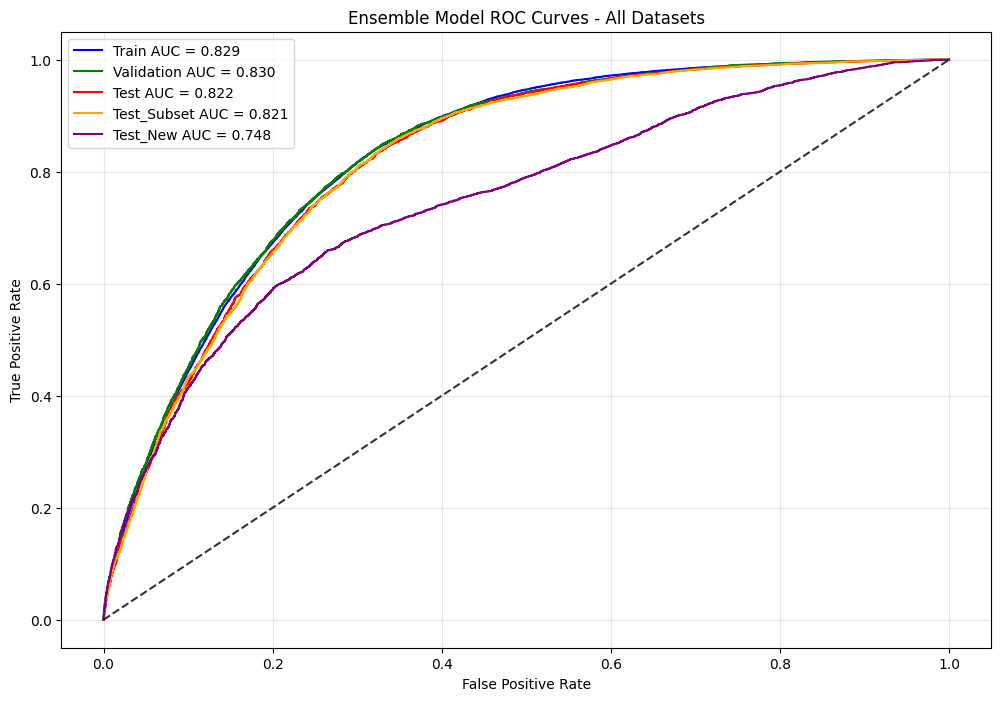

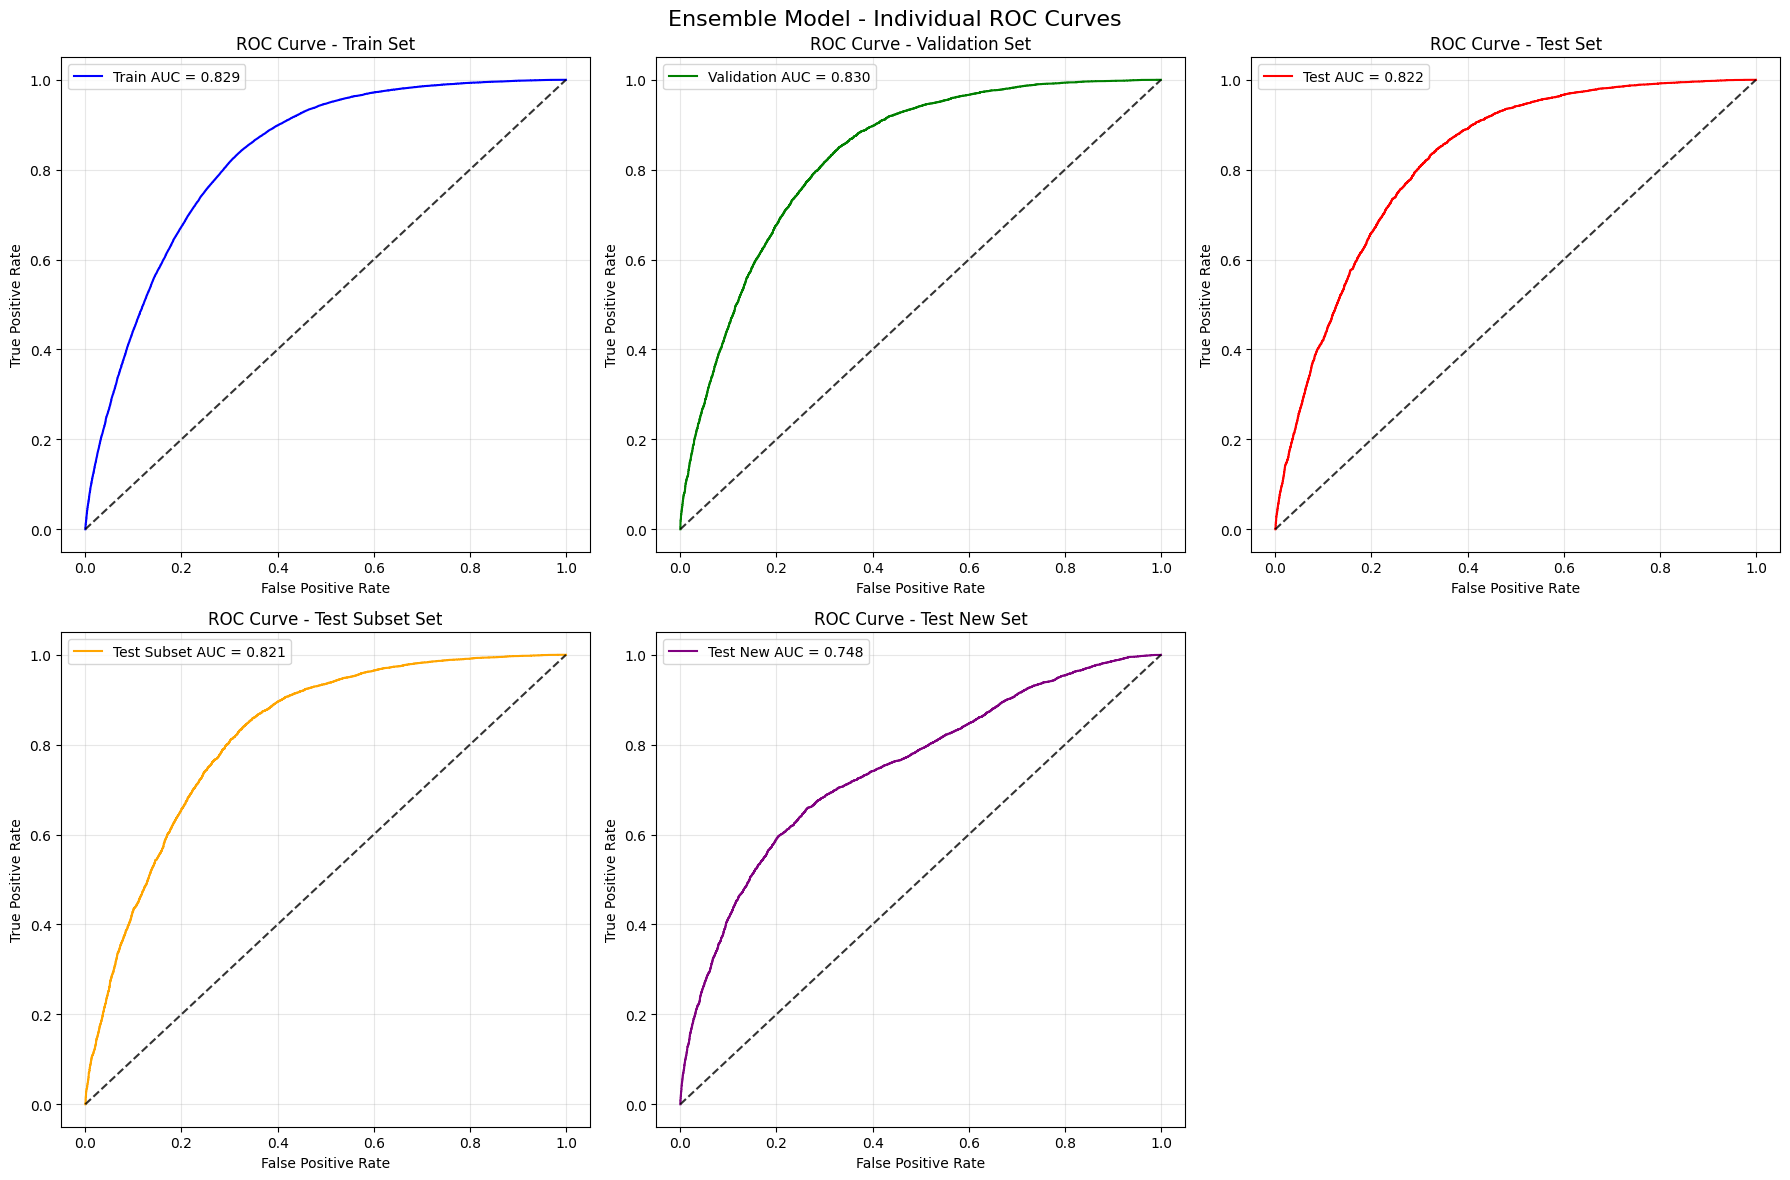

In [ ]:
def plot_ensemble_roc_curves(results_dict):

    plt.figure(figsize=(12, 8))
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    for i, (dataset_name, (targets, probs, preds)) in enumerate(results_dict.items()):
        fpr, tpr, _ = roc_curve(targets, probs)
        auc_score = roc_auc_score(targets, probs)

        plt.plot(fpr, tpr, color=colors[i % len(colors)],
                label=f'{dataset_name.title()} AUC = {auc_score:.3f}')

    plt.plot([0, 1], [0, 1], color='black', linestyle='--', alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Ensemble Model ROC Curves - All Datasets')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


ensemble_results = {
    'train': (train_targets, train_probs, train_preds),
    'validation': (val_targets, val_probs, val_preds),
    'test': (test_targets, test_probs, test_preds),
    'test_subset': (test_subset_targets, test_subset_probs, test_subset_preds),
    'test_new': (test_new_targets, test_new_probs, test_new_preds)
}


plot_ensemble_roc_curves(ensemble_results)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Ensemble Model - Individual ROC Curves', fontsize=16)

datasets = [
    ('Train', train_targets, train_probs, 'blue'),
    ('Validation', val_targets, val_probs, 'green'),
    ('Test', test_targets, test_probs, 'red'),
    ('Test Subset', test_subset_targets, test_subset_probs, 'orange'),
    ('Test New', test_new_targets, test_new_probs, 'purple')
]

for i, (name, targets, probs, color) in enumerate(datasets):
    row, col = i // 3, i % 3
    ax = axes[row, col]

    fpr, tpr, _ = roc_curve(targets, probs)
    auc_val = roc_auc_score(targets, probs)
    ax.plot(fpr, tpr, color=color, label=f'{name} AUC = {auc_val:.3f}')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.8)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {name} Set')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()

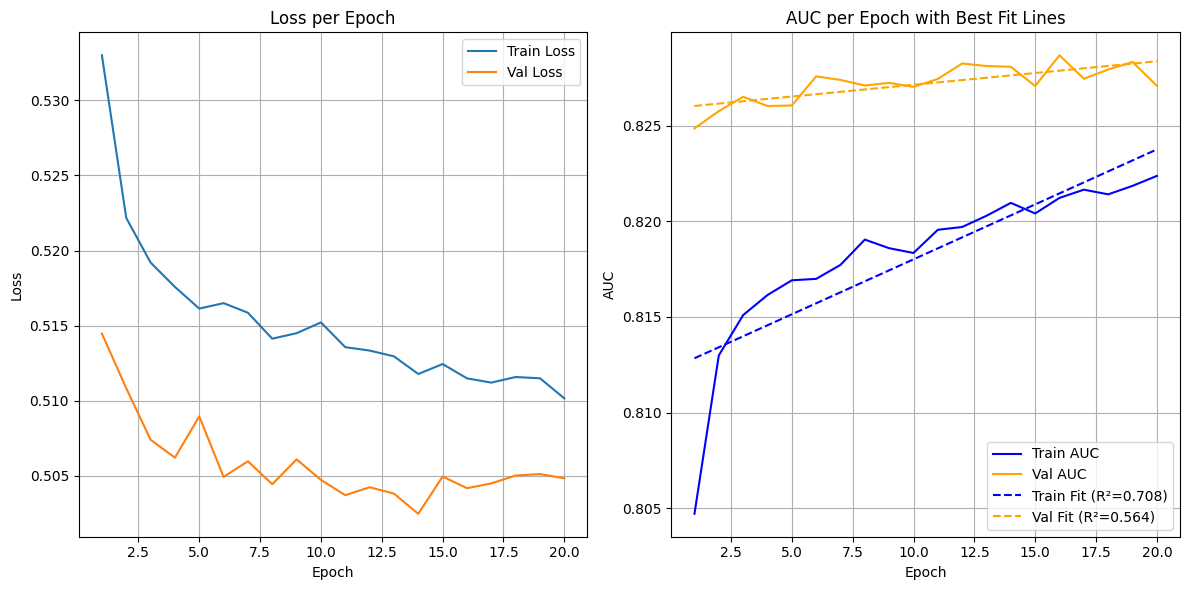

In [ ]:
best_single_trial = max(trial_summaries, key=lambda x: x['val_auc'])
best_history = best_single_trial['history']
fit_metrics = plot_loss_and_auc_with_fit(best_history)

In [ ]:
def ensemble_results_df(models, dataloader, weights=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if weights is None:
        weights = [1.0 / len(models)] * len(models)
    else:
        weights = np.array(weights)
        weights = weights / weights.sum()

    all_probs = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            batch_probs = torch.zeros(X_batch.size(0), device=device)

            for w, model in zip(weights, models):
                outputs, _ = model(X_batch)
                batch_probs += w * outputs.squeeze()

            all_probs.append(batch_probs.cpu().numpy())
            all_preds.append((batch_probs.cpu().numpy() >= 0.5).astype(int))
            all_targets.append(y_batch.numpy())

    probs = np.concatenate(all_probs)
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)

    targets = targets.flatten()
    probs = probs.flatten()
    preds = preds.flatten()

    df = pd.DataFrame({
        "true_label": targets,
        "ensemble_prob": probs,
        "ensemble_pred": preds
    })

    df["confidence_gap"] = np.abs(df["ensemble_prob"] - 0.5)
    return df

df_results = ensemble_results_df(models, test_new_loader, weights=weights, device=device)
df_loans = df_clean_new.reset_index(drop=True)
df_joined = pd.concat([df_loans, df_results], axis=1)

In [ ]:
N = 10

examples = df_joined[df_joined["true_label"] != df_joined["ensemble_pred"]].head(N)

for idx, row in examples.iterrows():
    print(f"=== Loan #{idx+1} ===")
    print("Loan Features:")
    print(row.drop(["true_label", "ensemble_prob", "ensemble_pred", "confidence_gap"]))
    print(f"\nTrue Label: {row['true_label']}")
    print(f"Ensemble Probability of Default: {row['ensemble_prob']:.4f}")
    print(f"Predicted Label: {row['ensemble_pred']}")
    print(f"Confidence Gap: {row['confidence_gap']:.4f}")
    print("="*40 + "\n")

=== Loan #1 ===
Loan Features:
annual_inc                    0.123961
emp_length                    1.538037
grade                         1.363346
loan_amnt                     2.537303
int_rate                      1.496357
default_ind                   1.000000
home_ownership_MORTGAGE       0.000000
home_ownership_NONE           0.000000
home_ownership_OTHER          0.000000
home_ownership_OWN            0.000000
home_ownership_RENT           1.000000
purpose_credit_card           0.000000
purpose_debt_consolidation    0.000000
purpose_educational           0.000000
purpose_home_improvement      0.000000
purpose_house                 0.000000
purpose_major_purchase        0.000000
purpose_medical               0.000000
purpose_moving                0.000000
purpose_other                 1.000000
purpose_renewable_energy      0.000000
purpose_small_business        0.000000
purpose_vacation              0.000000
purpose_wedding               0.000000
Name: 0, dtype: float64

True Lab

In [ ]:
N = 10

examples_corr = df_joined[df_joined["true_label"] == df_joined["ensemble_pred"]].head(N)

for idx, row in examples_corr.iterrows():
    print(f"=== Loan #{idx+1} ===")
    print("Loan Features:")
    print(row.drop(["true_label", "ensemble_prob", "ensemble_pred", "confidence_gap"]))
    print(f"\nTrue Label: {row['true_label']}")
    print(f"Ensemble Probability of Default: {row['ensemble_prob']:.4f}")
    print(f"Predicted Label: {row['ensemble_pred']}")
    print(f"Confidence Gap: {row['confidence_gap']:.4f}")
    print("="*40 + "\n")

=== Loan #3 ===
Loan Features:
annual_inc                   -3.266433
emp_length                   -1.114311
grade                         0.833305
loan_amnt                    -0.537115
int_rate                      0.745631
default_ind                   1.000000
home_ownership_MORTGAGE       1.000000
home_ownership_NONE           0.000000
home_ownership_OTHER          0.000000
home_ownership_OWN            0.000000
home_ownership_RENT           0.000000
purpose_credit_card           0.000000
purpose_debt_consolidation    0.000000
purpose_educational           0.000000
purpose_home_improvement      0.000000
purpose_house                 0.000000
purpose_major_purchase        0.000000
purpose_medical               1.000000
purpose_moving                0.000000
purpose_other                 0.000000
purpose_renewable_energy      0.000000
purpose_small_business        0.000000
purpose_vacation              0.000000
purpose_wedding               0.000000
Name: 2, dtype: float64

True Lab

Correcly classfied as true:

In [ ]:
N = 10

examples_1 = df_joined[
    (df_joined["true_label"] == df_joined["ensemble_pred"]) &
    (df_joined["true_label"] == 1)
].head(N)


for idx, row in examples_1.iterrows():
    print(f"=== Loan #{idx+1} ===")
    print("Loan Features:")
    print(row.drop(["true_label", "ensemble_prob", "ensemble_pred", "confidence_gap"]))
    print(f"\nTrue Label: {row['true_label']}")
    print(f"Ensemble Probability of Default: {row['ensemble_prob']:.4f}")
    print(f"Predicted Label: {row['ensemble_pred']}")
    print(f"Confidence Gap: {row['confidence_gap']:.4f}")
    print("="*40 + "\n")

=== Loan #7109 ===
Loan Features:
annual_inc                    0.214049
emp_length                   -0.313283
grade                         0.075346
loan_amnt                    -0.208431
int_rate                     -0.987144
default_ind                   0.000000
home_ownership_MORTGAGE       0.000000
home_ownership_NONE           0.000000
home_ownership_OTHER          0.000000
home_ownership_OWN            0.000000
home_ownership_RENT           1.000000
purpose_credit_card           0.000000
purpose_debt_consolidation    0.000000
purpose_educational           0.000000
purpose_home_improvement      0.000000
purpose_house                 0.000000
purpose_major_purchase        0.000000
purpose_medical               1.000000
purpose_moving                0.000000
purpose_other                 0.000000
purpose_renewable_energy      0.000000
purpose_small_business        0.000000
purpose_vacation              0.000000
purpose_wedding               0.000000
Name: 7108, dtype: float64

Tr

In [ ]:
N = 10

examples_1 = df_joined[
    (df_joined["true_label"] != df_joined["ensemble_pred"]) &
    (df_joined["true_label"] == 1)
].head(N)


for idx, row in examples_1.iterrows():
    print(f"=== Loan #{idx+1} ===")
    print("Loan Features:")
    print(row.drop(["true_label", "ensemble_prob", "ensemble_pred", "confidence_gap"]))
    print(f"\nTrue Label: {row['true_label']}")
    print(f"Ensemble Probability of Default: {row['ensemble_prob']:.4f}")
    print(f"Predicted Label: {row['ensemble_pred']}")
    print(f"Confidence Gap: {row['confidence_gap']:.4f}")
    print("="*40 + "\n")

=== Loan #7113 ===
Loan Features:
annual_inc                   -0.113189
emp_length                    0.594653
grade                         0.075346
loan_amnt                    -0.883123
int_rate                      0.099042
default_ind                   0.000000
home_ownership_MORTGAGE       1.000000
home_ownership_NONE           0.000000
home_ownership_OTHER          0.000000
home_ownership_OWN            0.000000
home_ownership_RENT           0.000000
purpose_credit_card           0.000000
purpose_debt_consolidation    0.000000
purpose_educational           1.000000
purpose_home_improvement      0.000000
purpose_house                 0.000000
purpose_major_purchase        0.000000
purpose_medical               0.000000
purpose_moving                0.000000
purpose_other                 0.000000
purpose_renewable_energy      0.000000
purpose_small_business        0.000000
purpose_vacation              0.000000
purpose_wedding               0.000000
Name: 7112, dtype: float64

Tr


Top 5 most attended feature pairs:
purpose_educational ↔ purpose_debt_consolidation: 0.1587
purpose_small_business ↔ purpose_debt_consolidation: 0.1469
revol_bal ↔ purpose_debt_consolidation: 0.1435
open_acc ↔ purpose_debt_consolidation: 0.1435
pub_rec ↔ purpose_debt_consolidation: 0.1435


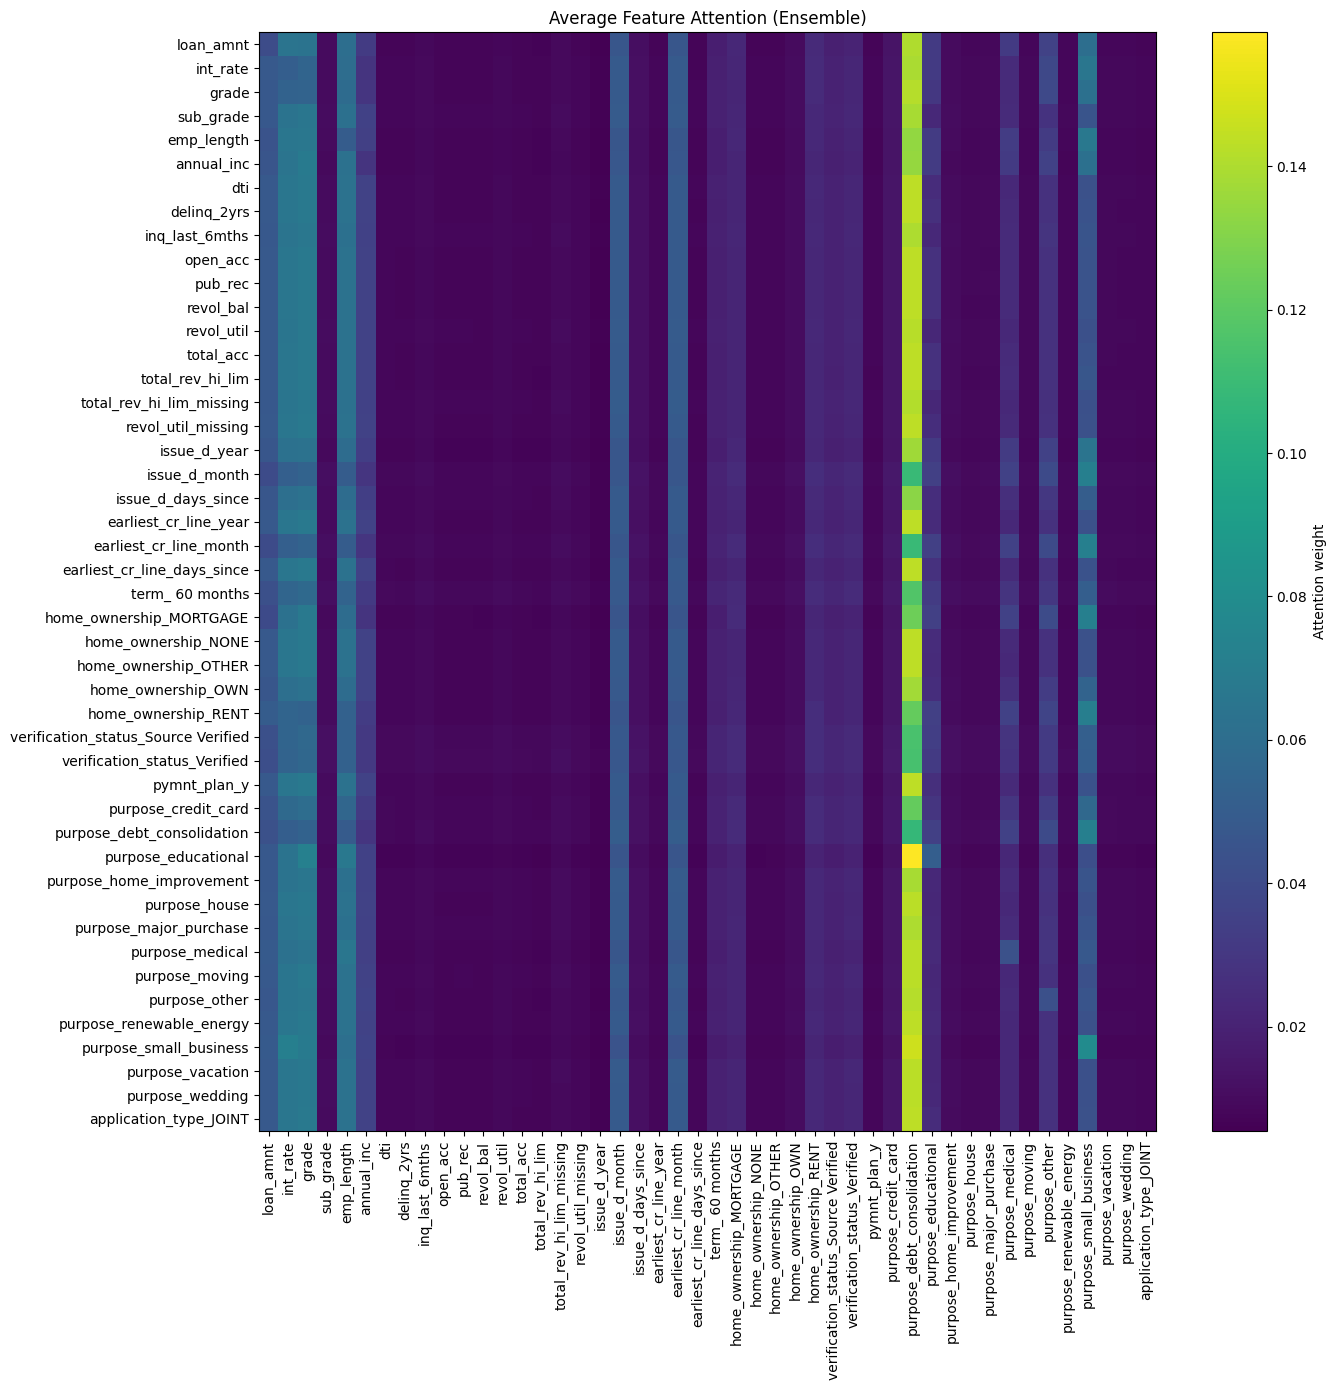

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools

# --- 1. Get feature names ---
feature_names = X_train.columns.tolist()  # guaranteed order & names


# --- 2. Get one batch ---
xb, yb = next(iter(test_new_loader))
xb = xb.to(device)

# --- 3. Collect attention weights from all models in ensemble ---
all_attn = []
for m in models:
    m.eval()
    with torch.no_grad():
        _, attn_weights = m.attention_branch(xb)  # shape likely (batch, heads, seq, seq)
        aw = attn_weights.detach().cpu().numpy()

        # Ensure shape: (batch, heads, seq, seq)
        if aw.ndim == 3:
            aw = np.expand_dims(aw, 1)  # add heads dim if missing
        all_attn.append(aw)

# --- 4. Average over ensemble, heads, and batch ---
attn_avg = np.mean(np.concatenate(all_attn, axis=0), axis=(0, 1))  # (seq, seq)

# --- 5. Extract top 5 most attended pairs ---
pairs = []
for i, j in itertools.product(range(attn_avg.shape[0]), repeat=2):
    if i != j:  # skip self-attention to same feature
        pairs.append(((feature_names[i], feature_names[j]), attn_avg[i, j]))

top_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 most attended feature pairs:")
for (f1, f2), score in top_pairs:
    print(f"{f1} ↔ {f2}: {score:.4f}")

# --- 6. Plot heatmap ---
plt.figure(figsize=(14, 14))
plt.imshow(attn_avg, cmap='viridis', aspect='auto')
plt.colorbar(label="Attention weight")
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.yticks(range(len(feature_names)), feature_names)
plt.title("Average Feature Attention (Ensemble)")
plt.tight_layout()
plt.show()


**purpose_educational:**	Loan was taken out for educational purposes (school, tuition, etc.)

**purpose_small_busines:** Loan was for starting/operating a small business

**purpose_debt_consolidation:** Loan was used to consolidate existing debt: revol_bal

**Revolving balance:** the amount currently owed on revolving credit accounts

open_acc:	Number of open credit accounts the borrower has

pub_rec:	Number of public derogatory records (like bankruptcies, liens)